In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from highlight_text import ax_text, fig_text
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
data = pd.read_csv('/kaggle/input/nyc-rat-sightings/Rat_Sightings.csv')

In [3]:
# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(data['Longitude'], data['Latitude'])]
gdf = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")

In [4]:
# Convert to Web Mercator projection 
gdf = gdf.to_crs(epsg=3857)

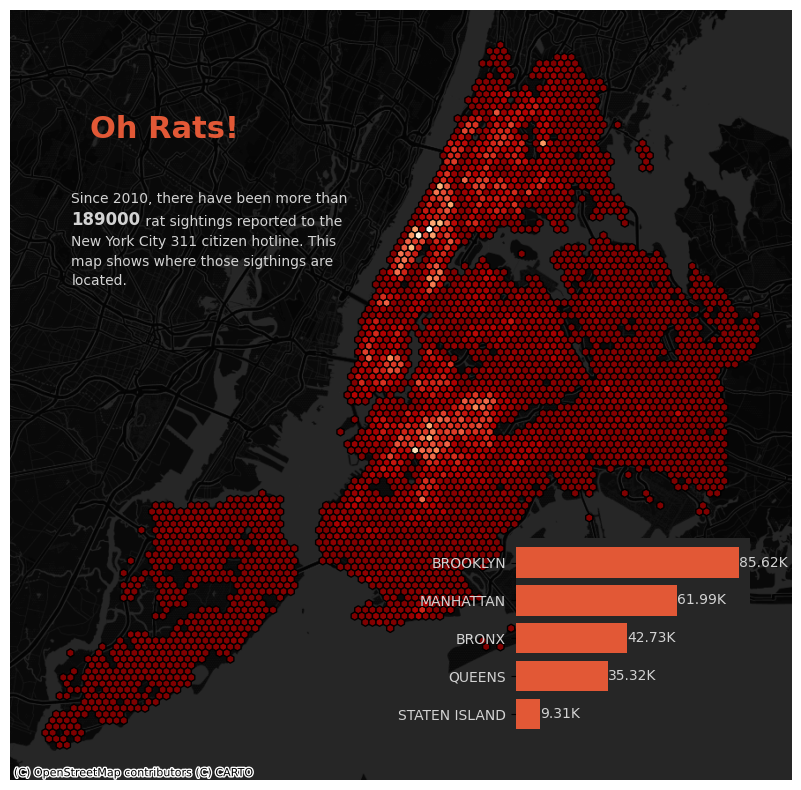

In [5]:
# Create hexbin plot
fig, ax = plt.subplots(figsize=(15, 10))
ax.axis('off')

# Create the hexbin
hb = ax.hexbin(gdf.geometry.x, gdf.geometry.y, 
               gridsize=100, cmap='OrRd_r', mincnt=1, reduce_C_function=np.sum, edgecolors='black')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatterNoLabels)

# Add texts

text_title = f"""
<Oh Rats!>
"""
fig_text(
   0.355, 0.76,
   text_title,
   fontsize=8,
   ha='center', va='center',
   color='lightgrey', 
   highlight_textprops=[
      {'fontweight': 'bold', 'color':'#e25836', 'fontsize': 22}
      ],
   fig=fig
)

text = f"""
Since 2010, there have been more than
<189000> rat sightings reported to the
New York City 311 citizen hotline. This
map shows where those sigthings are
located.
"""
fig_text(
   0.385, 0.65,
   text,
   fontsize=10,
   ha='center', va='center',
   color='lightgrey', 
   highlight_textprops=[
      {'fontweight': 'bold', 'fontsize': 12}
   ],
   fig=fig
)

# Create inset axes
inset_ax = inset_axes(ax, width="30%", height=2, loc="lower right", borderpad=3)
inset_ax.set_facecolor('#262626')  
inset_ax.tick_params(labelcolor='lightgrey')
inset_ax.spines['bottom'].set_color('none')
inset_ax.spines['top'].set_color('none')
inset_ax.spines['right'].set_color('none')
inset_ax.spines['left'].set_color('none')

# Filter out 'Unspecified' 
fd = data[data['Borough'] != 'Unspecified']

# Group by 'borough' and count the number of rows
bcounts = fd['Borough'].value_counts()

# Reverse the order of bars
bcounts = bcounts.iloc[::-1]

# Create bar plot
bars = inset_ax.barh(y=bcounts.index, width=bcounts.values, color='#e25836', zorder=2)
for bar, count in zip(bars, bcounts.values):
    inset_ax.text(bar.get_width() + 20, bar.get_y() + bar.get_height() / 2,
                  '{:.2f}K'.format(count / 1000),
                  ha='left', va='center', fontsize=10, color='lightgrey')

inset_ax.xaxis.set_visible(False)
plt.grid(axis='x', zorder=1, color='grey')

# Show plot
plt.show()